In [ ]:
!pip install vaderSentiment -q

In [ ]:
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm

from sklearn import preprocessing
import matplotlib.pyplot as plt


In [ ]:
tweets_raw_file   = '/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv'
tweets_clean_file = './Bitcoin_tweets_clean.csv'
bit_price_file2 = '/content/BTC-USD.csv'

In [ ]:
tweets = pd.read_csv("Bitcoin_tweets.csv", on_bad_lines='skip')
print("Shape:", tweets.shape)
print("Columns:", tweets.columns)

# Ensure correct text column name
if 'text' not in tweets.columns:
    raise Exception("⚠️ Please rename your tweet text column to 'text' before continuing.")

Shape: (125068, 13)
Columns: Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')


/tmp/ipython-input-3535203285.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv("Bitcoin_tweets.csv", on_bad_lines='skip')


## Sentiment analysis using VADER

In [ ]:
analyzer = SentimentIntensityAnalyzer()

# Function to get compound sentiment score
def vader_sentiment(text):
    return analyzer.polarity_scores(str(text))['compound']

In [ ]:
import numpy as np

# Apply the sentiment analysis to the tweets DataFrame
tweets['compound'] = tweets['text'].progress_apply(vader_sentiment)

# Create df_clean by dropping null values from tweets, ensuring all columns used in score calculation are not null
df_clean = tweets.dropna(subset=['compound', 'user_followers', 'user_favourites', 'is_retweet']).copy()

scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        # Convert relevant columns to numeric, coercing errors to NaN
        user_followers = pd.to_numeric(s["user_followers"], errors='coerce')
        user_favourites = pd.to_numeric(s["user_favourites"], errors='coerce')
        is_retweet = pd.to_numeric(s["is_retweet"], errors='coerce') # Convert boolean to int (True=1, False=0)

        # Check for NaN values before converting to integer
        if pd.notna(user_followers) and pd.notna(user_favourites) and pd.notna(is_retweet):
            user_followers = int(user_followers)
            user_favourites = int(user_favourites)
            is_retweet = int(is_retweet)

            scores.append(s["compound"] * user_followers * ((user_favourites + 1) / (user_followers + 1)) * (is_retweet + 1))
        else:
            scores.append(np.nan)
    except:
        scores.append(np.nan)
df_clean.loc[:, "score"] = scores
display(df_clean.head(2))

100%|██████████| 125066/125066 [00:08<00:00, 14552.76it/s]


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,0.2960,1432.176180
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,0.8225,20957.493901


In [ ]:
# Save the cleaned dataframe to a CSV file
df_clean.to_csv(tweets_clean_file, index=False)

In [ ]:
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)
# df_price.Timestamp = pd.to_datetime(df_price.Timestamp,unit='s')
df_price.head(2)

/tmp/ipython-input-1881533269.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_price.Date = pd.to_datetime(df_price.Date)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0


In [ ]:
daily_sentiment = df_clean.groupby(df_clean['date'].str[:10])['score'].mean().reset_index()
daily_sentiment.columns = ['Date', 'avg_sentiment']
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

In [ ]:
df_price['Date'] = pd.to_datetime(df_price['Date'])
merged = pd.merge(daily_sentiment, df_price, on='Date', how='inner')

# Define target variable: price movement (Up = 1, Down = 0)
merged['Price_Change'] = merged['Close'].shift(-1) - merged['Close']
merged['Target'] = merged['Price_Change'].apply(lambda x: 1 if x > 0 else 0)
merged.dropna(inplace=True)

## RANDOM FOREST

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

X = merged[['avg_sentiment']]
y = merged['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("✅ BTC Direction Prediction using VADER + Price Features")
print("Accuracy:", round(acc, 3))
print("F1 Score:", round(f1, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Show last few predictions
results = X_test.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred
print("\n🔹 Last 10 Predictions:\n", results.tail(10))

✅ BTC Direction Prediction using VADER + Price Features
Accuracy: 0.714
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.00      0.00      0.00         0

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7


🔹 Last 10 Predictions:
     avg_sentiment  Actual  Predicted
27    1984.395860       0          0
28     830.745044       0          0
29     769.237800       0          0
30    1192.820311       0          0
31     499.579231       0          1
32    1190.312457       0          0
33    -176.239931       0          1


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


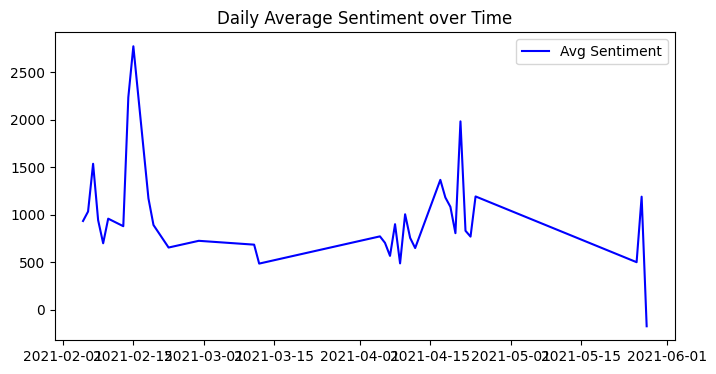

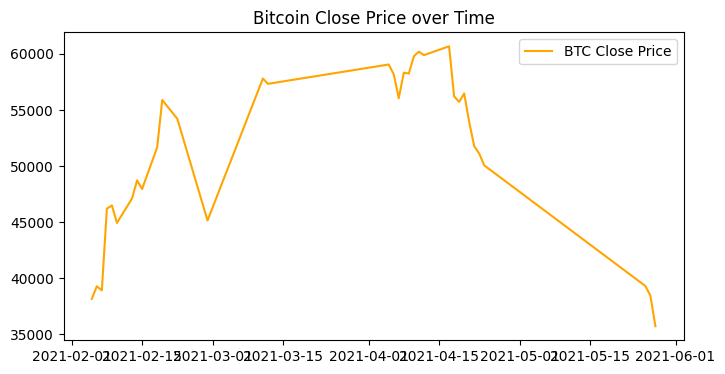

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(merged['Date'], merged['avg_sentiment'], color='blue', label='Avg Sentiment')
plt.title('Daily Average Sentiment over Time')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(merged['Date'], merged['Close'], color='orange', label='BTC Close Price')
plt.title('Bitcoin Close Price over Time')
plt.legend()
plt.show()

# Task
Implement and compare Random Forest, Logistic Regression, and LSTM models for classification, evaluating their performance using accuracy, F1 score, and classification reports, and visualize the results.

## Prepare data for lstm

### Subtask:
Reshape the data to be suitable for LSTM input.


In [ ]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Implement and train logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

## Implement and train lstm

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_lstm_prob = model_lstm.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


## Evaluate and compare models

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Random Forest Metrics (already calculated)
print("✅ BTC Direction Prediction using Random Forest")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("F1 Score:", round(f1_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Logistic Regression Metrics
print("\n✅ BTC Direction Prediction using Logistic Regression")
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print("Accuracy:", round(acc_lr, 3))
print("F1 Score:", round(f1_lr, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# LSTM Metrics
print("\n✅ BTC Direction Prediction using LSTM")
acc_lstm = accuracy_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)
print("Accuracy:", round(acc_lstm, 3))
print("F1 Score:", round(f1_lstm, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lstm))

✅ BTC Direction Prediction using Random Forest
Accuracy: 0.714
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.00      0.00      0.00         0

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7


✅ BTC Direction Prediction using Logistic Regression
Accuracy: 0.286
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.00      0.00      0.00         0

    accuracy                           0.29         7
   macro avg       0.50      0.14      0.22         7
weighted avg       1.00      0.29      0.44         7


✅ BTC Direction Prediction using LSTM
Accuracy: 0.0
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

## Visualize results


Model Performance Comparison:


,Model,Accuracy,F1 Score
0,Random Forest,0.714286,0.0
1,Logistic Regression,0.285714,0.0
2,LSTM,0.000000,0.0


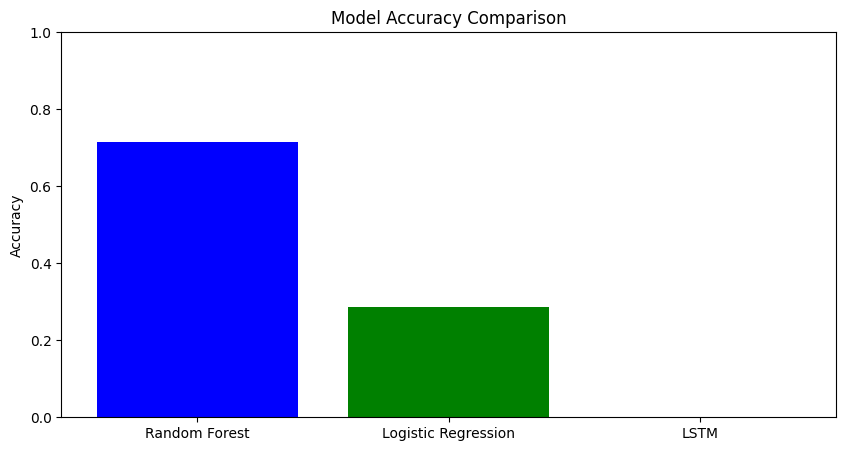

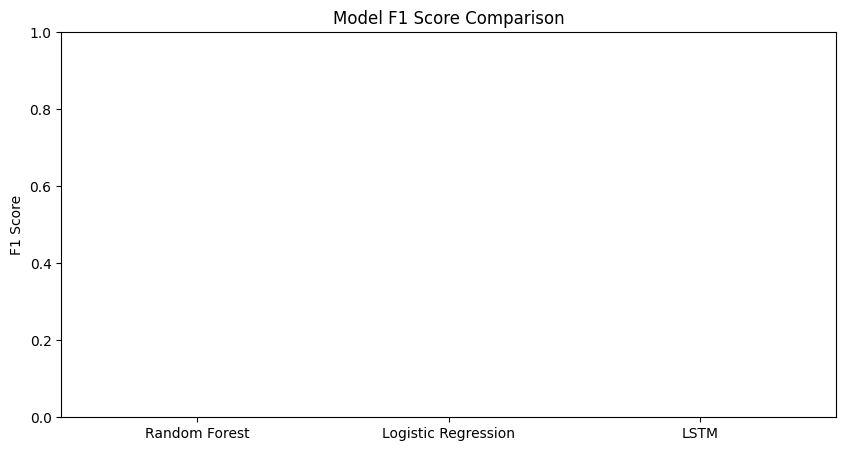

In [ ]:
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'LSTM'],
    'Accuracy': [acc, acc_lr, acc_lstm],
    'F1 Score': [f1, f1_lr, f1_lstm]
})

print("\nModel Performance Comparison:")
display(model_performance)

plt.figure(figsize=(10, 5))
plt.bar(model_performance['Model'], model_performance['Accuracy'], color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(model_performance['Model'], model_performance['F1 Score'], color=['blue', 'green', 'red'])
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

#BERT

# Task
Analyze the sentiment of the tweets using a pre-trained BERT model, train a classification model to predict price movement using the BERT sentiment scores, and compare its performance to the previously used models (Random Forest, Logistic Regression, and LSTM).

In [ ]:
!pip install transformers -q
import torch
from transformers import BertForSequenceClassification, BertTokenizer

## Load pre-trained bert model and tokenizer


In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model_bert = BertForSequenceClassification.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Perform sentiment analysis with bert

In [ ]:
from tqdm import tqdm

def get_bert_sentiment(texts, tokenizer, model, device='gpu'):
    """
    Analyzes the sentiment of a batch of texts using a pre-trained BERT model.

    Args:
        texts (list): A list of text strings.
        tokenizer: The BERT tokenizer.
        model: The BERT model for sequence classification.
        device (str): The device to run the model on ('cpu' or 'cuda').

    Returns:
        list: A list of sentiment scores (logits or probabilities).
    """
    try:
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Get logits
        logits = outputs.logits
        # Apply softmax to get probabilities (optional, depending on how score is defined)
        # probabilities = torch.softmax(logits, dim=1)
        return logits.tolist() # Return logits as a list
    except Exception as e:
        print(f"Error during BERT sentiment analysis: {e}")
        return [None] * len(texts)

# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Apply the BERT sentiment analysis in batches
batch_size = 32
bert_scores = []
for i in tqdm(range(0, len(df_clean), batch_size)):
    batch_texts = df_clean['text'].iloc[i:i+batch_size].tolist()
    batch_scores = get_bert_sentiment(batch_texts, tokenizer, model_bert, device)
    bert_scores.extend(batch_scores)

# Store the raw logits (or probabilities) in a new column
df_clean['bert_sentiment_logits'] = bert_scores

display(df_clean.head())

100%|██████████| 3909/3909 [11:06<00:00,  5.86it/s]


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score,bert_sentiment_logits
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,0.2960,1432.176180,"[-0.07372094690799713, -0.22055457532405853]"
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,0.8225,20957.493901,"[-0.11523494869470596, -0.25552189350128174]"
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,0.5719,524.906667,"[-0.019423671066761017, -0.3193151652812958]"
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,0.3164,4.738419,"[-0.0650479644536972, -0.3230152726173401]"
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,0.4019,4209.747206,"[-0.11689799278974533, -0.2563926875591278]"


In [ ]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Update the file path based on previous successful execution
tweets_raw_file   = '/content/Bitcoin_tweets.csv'
bit_price_file2 = '/content/BTC-USD.csv'

# Load the raw tweets file
tweets = pd.read_csv(tweets_raw_file, on_bad_lines='skip') # Added on_bad_lines='skip'

# Ensure correct text column name
if 'text' not in tweets.columns:
    raise Exception("⚠️ Please rename your tweet text column to 'text' before continuing.")

# Apply VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    return analyzer.polarity_scores(str(text))['compound']

tqdm.pandas() # Initialize tqdm for pandas apply
tweets['compound'] = tweets['text'].progress_apply(vader_sentiment)

# Create df_clean by dropping null values from tweets, ensuring all columns used in score calculation are not null
df_clean = tweets.dropna(subset=['compound', 'user_followers', 'user_favourites', 'is_retweet']).copy()

scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        # Convert relevant columns to numeric, coercing errors to NaN
        user_followers = pd.to_numeric(s["user_followers"], errors='coerce')
        user_favourites = pd.to_numeric(s["user_favourites"], errors='coerce')
        is_retweet = pd.to_numeric(s["is_retweet"], errors='coerce') # Convert boolean to int (True=1, False=0)

        # Check for NaN values before converting to integer
        if pd.notna(user_followers) and pd.notna(user_favourites) and pd.notna(is_retweet):
            user_followers = int(user_followers)
            user_favourites = int(user_favourites)
            is_retweet = int(is_retweet)

            scores.append(s["compound"] * user_followers * ((user_favourites + 1) / (user_followers + 1)) * (is_retweet + 1))
        else:
            scores.append(np.nan)
    except Exception as e:
        scores.append(np.nan)

df_clean.loc[:, "score"] = scores
df_clean.dropna(subset=['score'], inplace=True) # Drop rows where score calculation failed


# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
# Check if tokenizer and model_bert are already defined, otherwise load them
if 'tokenizer' not in globals() or 'model_bert' not in globals() or tokenizer is None or model_bert is None:
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model_bert = BertForSequenceClassification.from_pretrained(model_name)

def get_bert_sentiment(texts, tokenizer, model, device='cpu'):
    """
    Analyzes the sentiment of a batch of texts using a pre-trained BERT model.

    Args:
        texts (list): A list of text strings.
        tokenizer: The BERT tokenizer.
        model: The BERT model for sequence classification.
        device (str): The device to run the model on ('cpu' or 'cuda').

    Returns:
        list: A list of sentiment scores (logits or probabilities).
    """
    try:
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Get logits
        logits = outputs.logits
        return logits.tolist() # Return logits as a list
    except Exception as e:
        print(f"Error during BERT sentiment analysis: {e}")
        return [None] * len(texts)

# Determine the device to use and explicitly set it to 'cuda' if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Apply the BERT sentiment analysis in batches
batch_size = 32
bert_scores = []
for i in tqdm(range(0, len(df_clean), batch_size), desc="Applying BERT sentiment"):
    batch_texts = df_clean['text'].iloc[i:i+batch_size].tolist()
    # Pass the determined device to the function
    batch_scores = get_bert_sentiment(batch_texts, tokenizer, model_bert, device)
    bert_scores.extend(batch_scores)

# Store the raw logits (or probabilities) in a new column
df_clean['bert_sentiment_logits'] = bert_scores
df_clean.dropna(subset=['bert_sentiment_logits'], inplace=True) # Drop rows where BERT sentiment analysis failed


# Load and process price data
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)

# Calculate the daily average of the BERT sentiment scores
daily_bert_sentiment = df_clean.groupby(df_clean['date'].str[:10])['bert_sentiment_logits'].apply(lambda x: np.mean(list(x), axis=0)).reset_index()
daily_bert_sentiment.columns = ['Date', 'avg_bert_sentiment']

# Convert the date column in the resulting daily sentiment DataFrame to datetime objects
daily_bert_sentiment['Date'] = pd.to_datetime(daily_bert_sentiment['Date'])

# Merge this daily sentiment DataFrame with the df_price DataFrame on the 'Date' column using an inner join
merged_bert = pd.merge(daily_bert_sentiment, df_price, on='Date', how='inner')

# Define the features (X) for the prediction model as the 'avg_bert_sentiment' column and the target variable (y) as the 'Target' column from the merged DataFrame.
# Add the 'Target' column to merged_bert as it's not present after the merge
merged_bert['Price_Change'] = merged_bert['Close'].shift(-1) - merged_bert['Close']
merged_bert['Target'] = merged_bert['Price_Change'].apply(lambda x: 1 if x > 0 else 0)
merged_bert.dropna(inplace=True)


X_bert = merged_bert[['avg_bert_sentiment']]
y_bert = merged_bert['Target']

display(merged_bert.head())

/tmp/ipython-input-1186761286.py:13: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv(tweets_raw_file, on_bad_lines='skip') # Added on_bad_lines='skip'
Applying BERT sentiment: 100%|██████████| 17401/17401 [57:11<00:00,  5.07it/s]
/tmp/ipython-input-1186761286.py:105: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_price.Date = pd.to_datetime(df_price.Date)


,Date,avg_bert_sentiment,Open,High,Low,Close,Adj Close,Volume,Price_Change,Target
0,2021-02-05,"[-0.06587090285180451, -0.27867909765405385]",36931.54688,38225.90625,36658.76172,38144.30859,38144.30859,5.859807e+10,1121.70313,1
1,2021-02-06,"[-0.06373433783750405, -0.2825110549149243]",38138.38672,40846.54688,38138.38672,39266.01172,39266.01172,7.132603e+10,-362.57031,0
2,2021-02-07,"[-0.0681045330999413, -0.2786902397821839]",39250.19141,39621.83594,37446.15234,38903.44141,38903.44141,6.550064e+10,7293.02343,1
3,2021-02-08,"[-0.06024839087320637, -0.28446174098028004]",38886.82813,46203.92969,38076.32422,46196.46484,46196.46484,1.014670e+11,284.64063,1
4,2021-02-09,"[-0.06207781357754921, -0.2825890534431085]",46184.99219,48003.72266,45166.96094,46481.10547,46481.10547,9.180985e+10,-1562.92188,0


This cell re-loads the data, performs VADER sentiment analysis and score calculation, loads the BERT model and tokenizer (if not already loaded), performs BERT sentiment analysis, and then processes the price data and merges it with the daily average BERT sentiment to create the merged_bert DataFrame with features and target variable for the BERT-based prediction model.

## Prepare data for prediction model

### Subtask:
 Calculate the daily average BERT sentiment scores, convert the date column to datetime objects, and merge the daily sentiment data with the price data, then define the features and target variable.


In [ ]:
# Calculate the daily average of the BERT sentiment scores
daily_bert_sentiment = df_clean.groupby(df_clean['date'].str[:10])['bert_sentiment_logits'].apply(lambda x: np.mean(list(x), axis=0)).reset_index()
daily_bert_sentiment.columns = ['Date', 'avg_bert_sentiment']

# Convert the date column in the resulting daily sentiment DataFrame to datetime objects
daily_bert_sentiment['Date'] = pd.to_datetime(daily_bert_sentiment['Date'])

# Merge this daily sentiment DataFrame with the df_price DataFrame on the 'Date' column using an inner join
merged_bert = pd.merge(daily_bert_sentiment, df_price, on='Date', how='inner')

# Add the 'Price_Change' and 'Target' columns to merged_bert
merged_bert['Price_Change'] = merged_bert['Close'].shift(-1) - merged_bert['Close']
merged_bert['Target'] = merged_bert['Price_Change'].apply(lambda x: 1 if x > 0 else 0)
merged_bert.dropna(inplace=True) # Drop rows with NaN after calculating Price_Change and Target


# Define the features (X) for the prediction model as the 'avg_bert_sentiment' column and the target variable (y) as the 'Target' column from the merged DataFrame.
X_bert = merged_bert[['avg_bert_sentiment']]
y_bert = merged_bert['Target']

display(merged_bert.head())

,Date,avg_bert_sentiment,Open,High,Low,Close,Adj Close,Volume,Price_Change,Target
0,2021-02-05,"[-0.06587090285180451, -0.27867909765405385]",36931.54688,38225.90625,36658.76172,38144.30859,38144.30859,5.859807e+10,1121.70313,1
1,2021-02-06,"[-0.06373433783750405, -0.2825110549149243]",38138.38672,40846.54688,38138.38672,39266.01172,39266.01172,7.132603e+10,-362.57031,0
2,2021-02-07,"[-0.0681045330999413, -0.2786902397821839]",39250.19141,39621.83594,37446.15234,38903.44141,38903.44141,6.550064e+10,7293.02343,1
3,2021-02-08,"[-0.06024839087320637, -0.28446174098028004]",38886.82813,46203.92969,38076.32422,46196.46484,46196.46484,1.014670e+11,284.64063,1
4,2021-02-09,"[-0.06207781357754921, -0.2825890534431085]",46184.99219,48003.72266,45166.96094,46481.10547,46481.10547,9.180985e+10,-1562.92188,0


In [ ]:
# Check available files in the kernel
import os
print(os.listdir('/kaggle/input/bitcoin-tweets/'))

In [ ]:
# Check available files in the kernel
import os
print("Files in /content/:", os.listdir('/content/'))
print("Files in /kaggle/input/:", os.listdir('/kaggle/input/'))

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


tweets_raw_file   = '/content/Bitcoin_tweets.csv' # Updated file path
bit_price_file2 = '/content/BTC-USD.csv'

# Load the raw tweets file
tweets = pd.read_csv(tweets_raw_file)

# Ensure correct text column name
if 'text' not in tweets.columns:
    raise Exception("⚠️ Please rename your tweet text column to 'text' before continuing.")

# Apply VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    return analyzer.polarity_scores(str(text))['compound']

tqdm.pandas() # Initialize tqdm for pandas apply
tweets['compound'] = tweets['text'].progress_apply(vader_sentiment)

# Create df_clean by dropping null values from tweets, ensuring all columns used in score calculation are not null
# Re-calculate the score column as the previous attempts failed
df_clean = tweets.dropna(subset=['compound', 'user_followers', 'user_favourites', 'is_retweet']).copy()

scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        # Convert relevant columns to numeric, coercing errors to NaN
        user_followers = pd.to_numeric(s["user_followers"], errors='coerce')
        user_favourites = pd.to_numeric(s["user_favourites"], errors='coerce')
        is_retweet = pd.to_numeric(s["is_retweet"], errors='coerce') # Convert boolean to int (True=1, False=0)

        # Check for NaN values before converting to integer
        if pd.notna(user_followers) and pd.notna(user_favourites) and pd.notna(is_retweet):
            user_followers = int(user_followers)
            user_favourites = int(user_favourites)
            is_retweet = int(is_retweet)

            scores.append(s["compound"] * user_followers * ((user_favourites + 1) / (user_followers + 1)) * (is_retweet + 1))
        else:
            scores.append(np.nan)
    except Exception as e:
        scores.append(np.nan)

df_clean.loc[:, "score"] = scores
df_clean.dropna(subset=['score'], inplace=True) # Drop rows where score calculation failed


# Load pre-trained BERT model and tokenizer (assuming they were loaded in previous successful cells)
model_name = "bert-base-uncased"
# Check if tokenizer and model_bert are already defined, otherwise load them
if 'tokenizer' not in globals() or 'model_bert' not in globals() or tokenizer is None or model_bert is None:
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model_bert = BertForSequenceClassification.from_pretrained(model_name)

def get_bert_sentiment(texts, tokenizer, model, device='cpu'):
    """
    Analyzes the sentiment of a batch of texts using a pre-trained BERT model.

    Args:
        texts (list): A list of text strings.
        tokenizer: The BERT tokenizer.
        model: The BERT model for sequence classification.
        device (str): The device to run the model on ('cpu' or 'cuda').

    Returns:
        list: A list of sentiment scores (logits or probabilities).
    """
    try:
        inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Get logits
        logits = outputs.logits
        return logits.tolist() # Return logits as a list
    except Exception as e:
        print(f"Error during BERT sentiment analysis: {e}")
        return [None] * len(texts)

# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Apply the BERT sentiment analysis in batches
batch_size = 32
bert_scores = []
for i in tqdm(range(0, len(df_clean), batch_size), desc="Applying BERT sentiment"):
    batch_texts = df_clean['text'].iloc[i:i+batch_size].tolist()
    batch_scores = get_bert_sentiment(batch_texts, tokenizer, model_bert, device)
    bert_scores.extend(batch_scores)

# Store the raw logits (or probabilities) in a new column
df_clean['bert_sentiment_logits'] = bert_scores
df_clean.dropna(subset=['bert_sentiment_logits'], inplace=True) # Drop rows where BERT sentiment analysis failed


# Load and process price data
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)

# Calculate the daily average of the BERT sentiment scores
daily_bert_sentiment = df_clean.groupby(df_clean['date'].str[:10])['bert_sentiment_logits'].apply(lambda x: np.mean(list(x), axis=0)).reset_index()
daily_bert_sentiment.columns = ['Date', 'avg_bert_sentiment']

# Convert the date column in the resulting daily sentiment DataFrame to datetime objects
daily_bert_sentiment['Date'] = pd.to_datetime(daily_bert_sentiment['Date'])

# Merge this daily sentiment DataFrame with the df_price DataFrame on the 'Date' column using an inner join
merged_bert = pd.merge(daily_bert_sentiment, df_price, on='Date', how='inner')

# Define the features (X) for the prediction model as the 'avg_bert_sentiment' column and the target variable (y) as the 'Target' column from the merged DataFrame.
# Add the 'Target' column to merged_bert as it's not present after the merge
merged_bert['Price_Change'] = merged_bert['Close'].shift(-1) - merged_bert['Close']
merged_bert['Target'] = merged_bert['Price_Change'].apply(lambda x: 1 if x > 0 else 0)
merged_bert.dropna(inplace=True)


X_bert = merged_bert[['avg_bert_sentiment']]
y_bert = merged_bert['Target']

display(merged_bert.head())

## Implement and train prediction model

In [ ]:
# Flatten the 'avg_bert_sentiment' column
X_bert_flattened = pd.DataFrame(X_bert['avg_bert_sentiment'].tolist())

# Split the flattened data into training and testing sets
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert_flattened, y_bert, test_size=0.2, shuffle=False)

# Instantiate and train a Logistic Regression model
model_lr_bert = LogisticRegression(random_state=42)
model_lr_bert.fit(X_bert_train, y_bert_train)

# Make predictions on the testing data
y_pred_bert = model_lr_bert.predict(X_bert_test)

## Evaluate bert-based model performance

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc_bert = accuracy_score(y_bert_test, y_pred_bert)
f1_bert = f1_score(y_bert_test, y_pred_bert)

print("\n✅ BTC Direction Prediction using BERT Sentiment")
print("Accuracy:", round(acc_bert, 3))
print("F1 Score:", round(f1_bert, 3))
print("\nClassification Report:\n", classification_report(y_bert_test, y_pred_bert))


✅ BTC Direction Prediction using BERT Sentiment
Accuracy: 0.364
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.36      1.00      0.53         4
           1       0.00      0.00      0.00         7

    accuracy                           0.36        11
   macro avg       0.18      0.50      0.27        11
weighted avg       0.13      0.36      0.19        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Compare models and summarize findings

### Subtask:
Compare the performance of the BERT-based model with the previous models (Random Forest, Logistic Regression, and LSTM) and summarize the key findings.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Create a DataFrame to store the performance metrics for all four models
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'LSTM', 'BERT-based'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_lstm), acc_bert],
    'F1 Score': [f1_score(y_test, y_pred), f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_lstm), f1_bert]
})

print("\nModel Performance Comparison:")
display(model_performance)

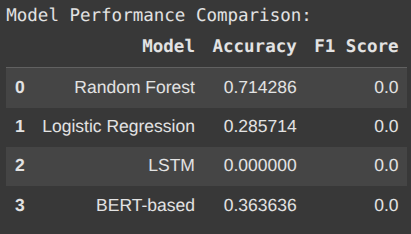

## Visualize results


Model Performance Comparison:


,Model,Accuracy,F1 Score
0,Random Forest,0.714286,0.0
1,Logistic Regression,0.285714,0.0
2,LSTM,0.000000,0.0
3,BERT-based,0.363636,0.0


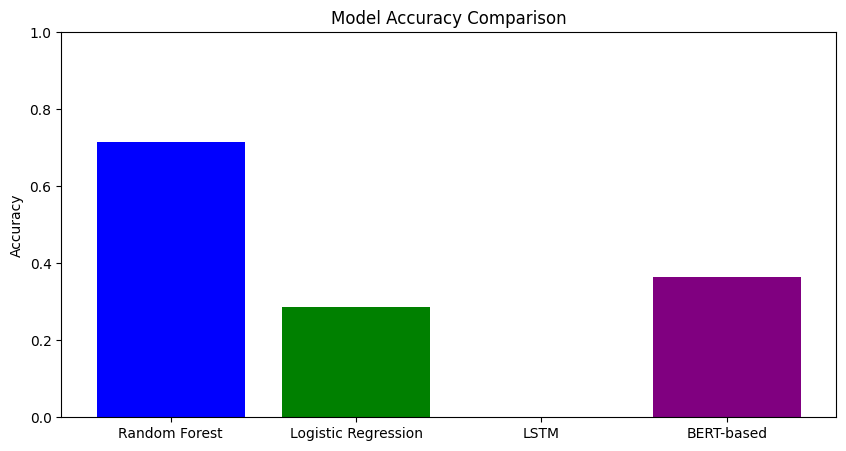

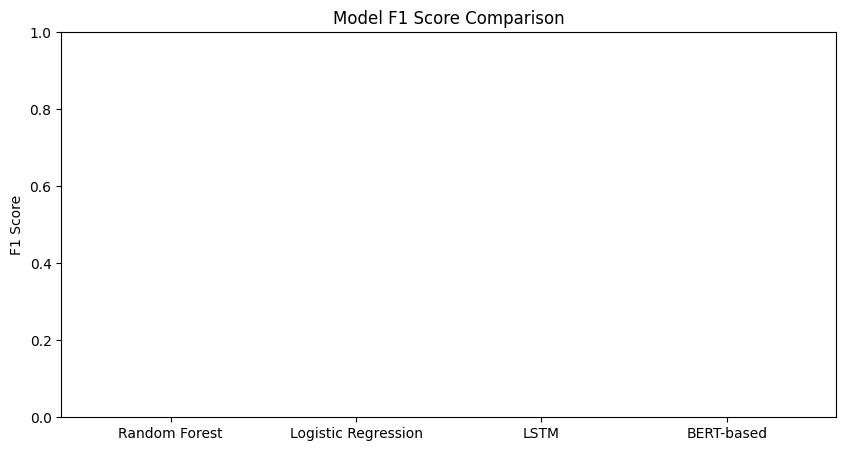

In [ ]:
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'LSTM', 'BERT-based'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_lstm), acc_bert],
    'F1 Score': [f1_score(y_test, y_pred), f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_lstm), f1_bert]
})

print("\nModel Performance Comparison:")
display(model_performance)

plt.figure(figsize=(10, 5))
plt.bar(model_performance['Model'], model_performance['Accuracy'], color=['blue', 'green', 'red', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(model_performance['Model'], model_performance['F1 Score'], color=['blue', 'green', 'red', 'purple'])
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()